# scRNA-seq analysis

Here we will use 10X PBMCs scRNA-seq dataset as an example to illustrate how SIMBA performs scRNA-seq analysis

In [1]:
import os
import simba as si
si.__version__

/srv/local/jayoung/conda/envs/jy_simba_copy/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'1.2'

In [2]:
workdir = 'result_simba_rnaseq_allgenes'
si.settings.set_workdir(workdir)

Saving results in: result_simba_rnaseq_allgenes


In [3]:
si.settings.set_figure_params(dpi=80,
                              style='white',
                              fig_size=[5,5],
                              rc={'image.cmap': 'viridis'})

In [4]:
# make plots prettier
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

/tmp/ipykernel_7623/3704955539.py:3: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


### load example data

In [5]:
adata_CG = si.datasets.rna_10xpmbc3k()

In [6]:
adata_CG

AnnData object with n_obs × n_vars = 2700 × 32738
    obs: 'celltype'
    var: 'gene_ids'

### preprocessing

In [7]:
si.pp.filter_genes(adata_CG,min_n_cells=3)

Before filtering: 
2700 cells, 32738 genes
Filter genes based on min_n_cells
After filtering out low-expressed genes: 
2700 cells, 13714 genes


In [8]:
si.pp.cal_qc_rna(adata_CG)

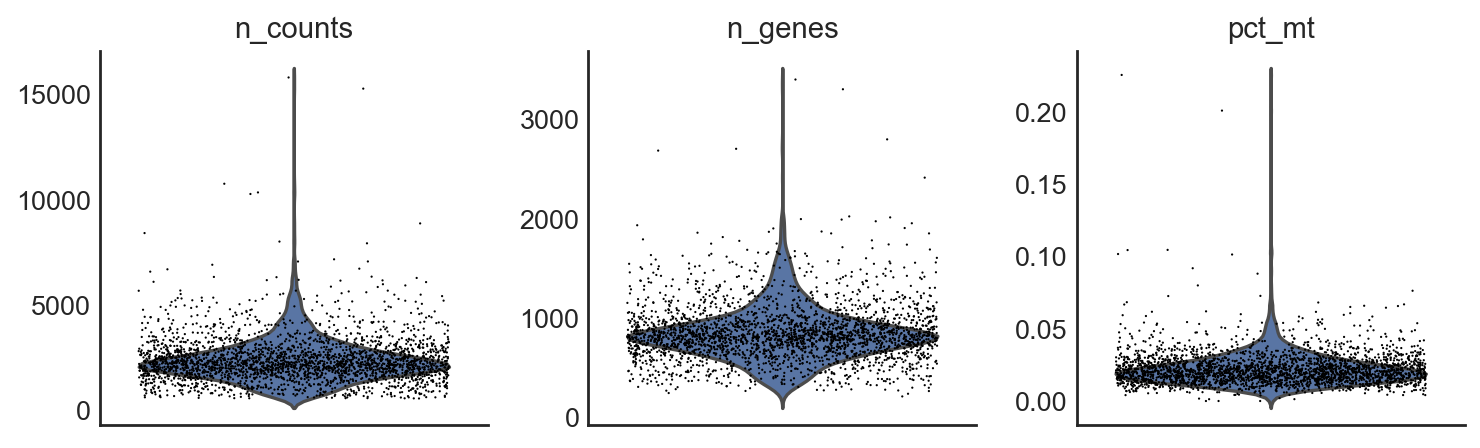

In [9]:
si.pl.violin(adata_CG,list_obs=['n_counts','n_genes','pct_mt'])

Filter out cells if needed:

```python
si.pp.filter_cells_rna(adata,min_n_genes=100)
```

In [10]:
si.pp.normalize(adata_CG,method='lib_size')

In [11]:
si.pp.log_transform(adata_CG)

In [12]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

In [16]:
adata_CG[:,'IL7R'].X

<2700x1 sparse matrix of type '<class 'numpy.float32'>'
	with 1085 stored elements in Compressed Sparse Row format>

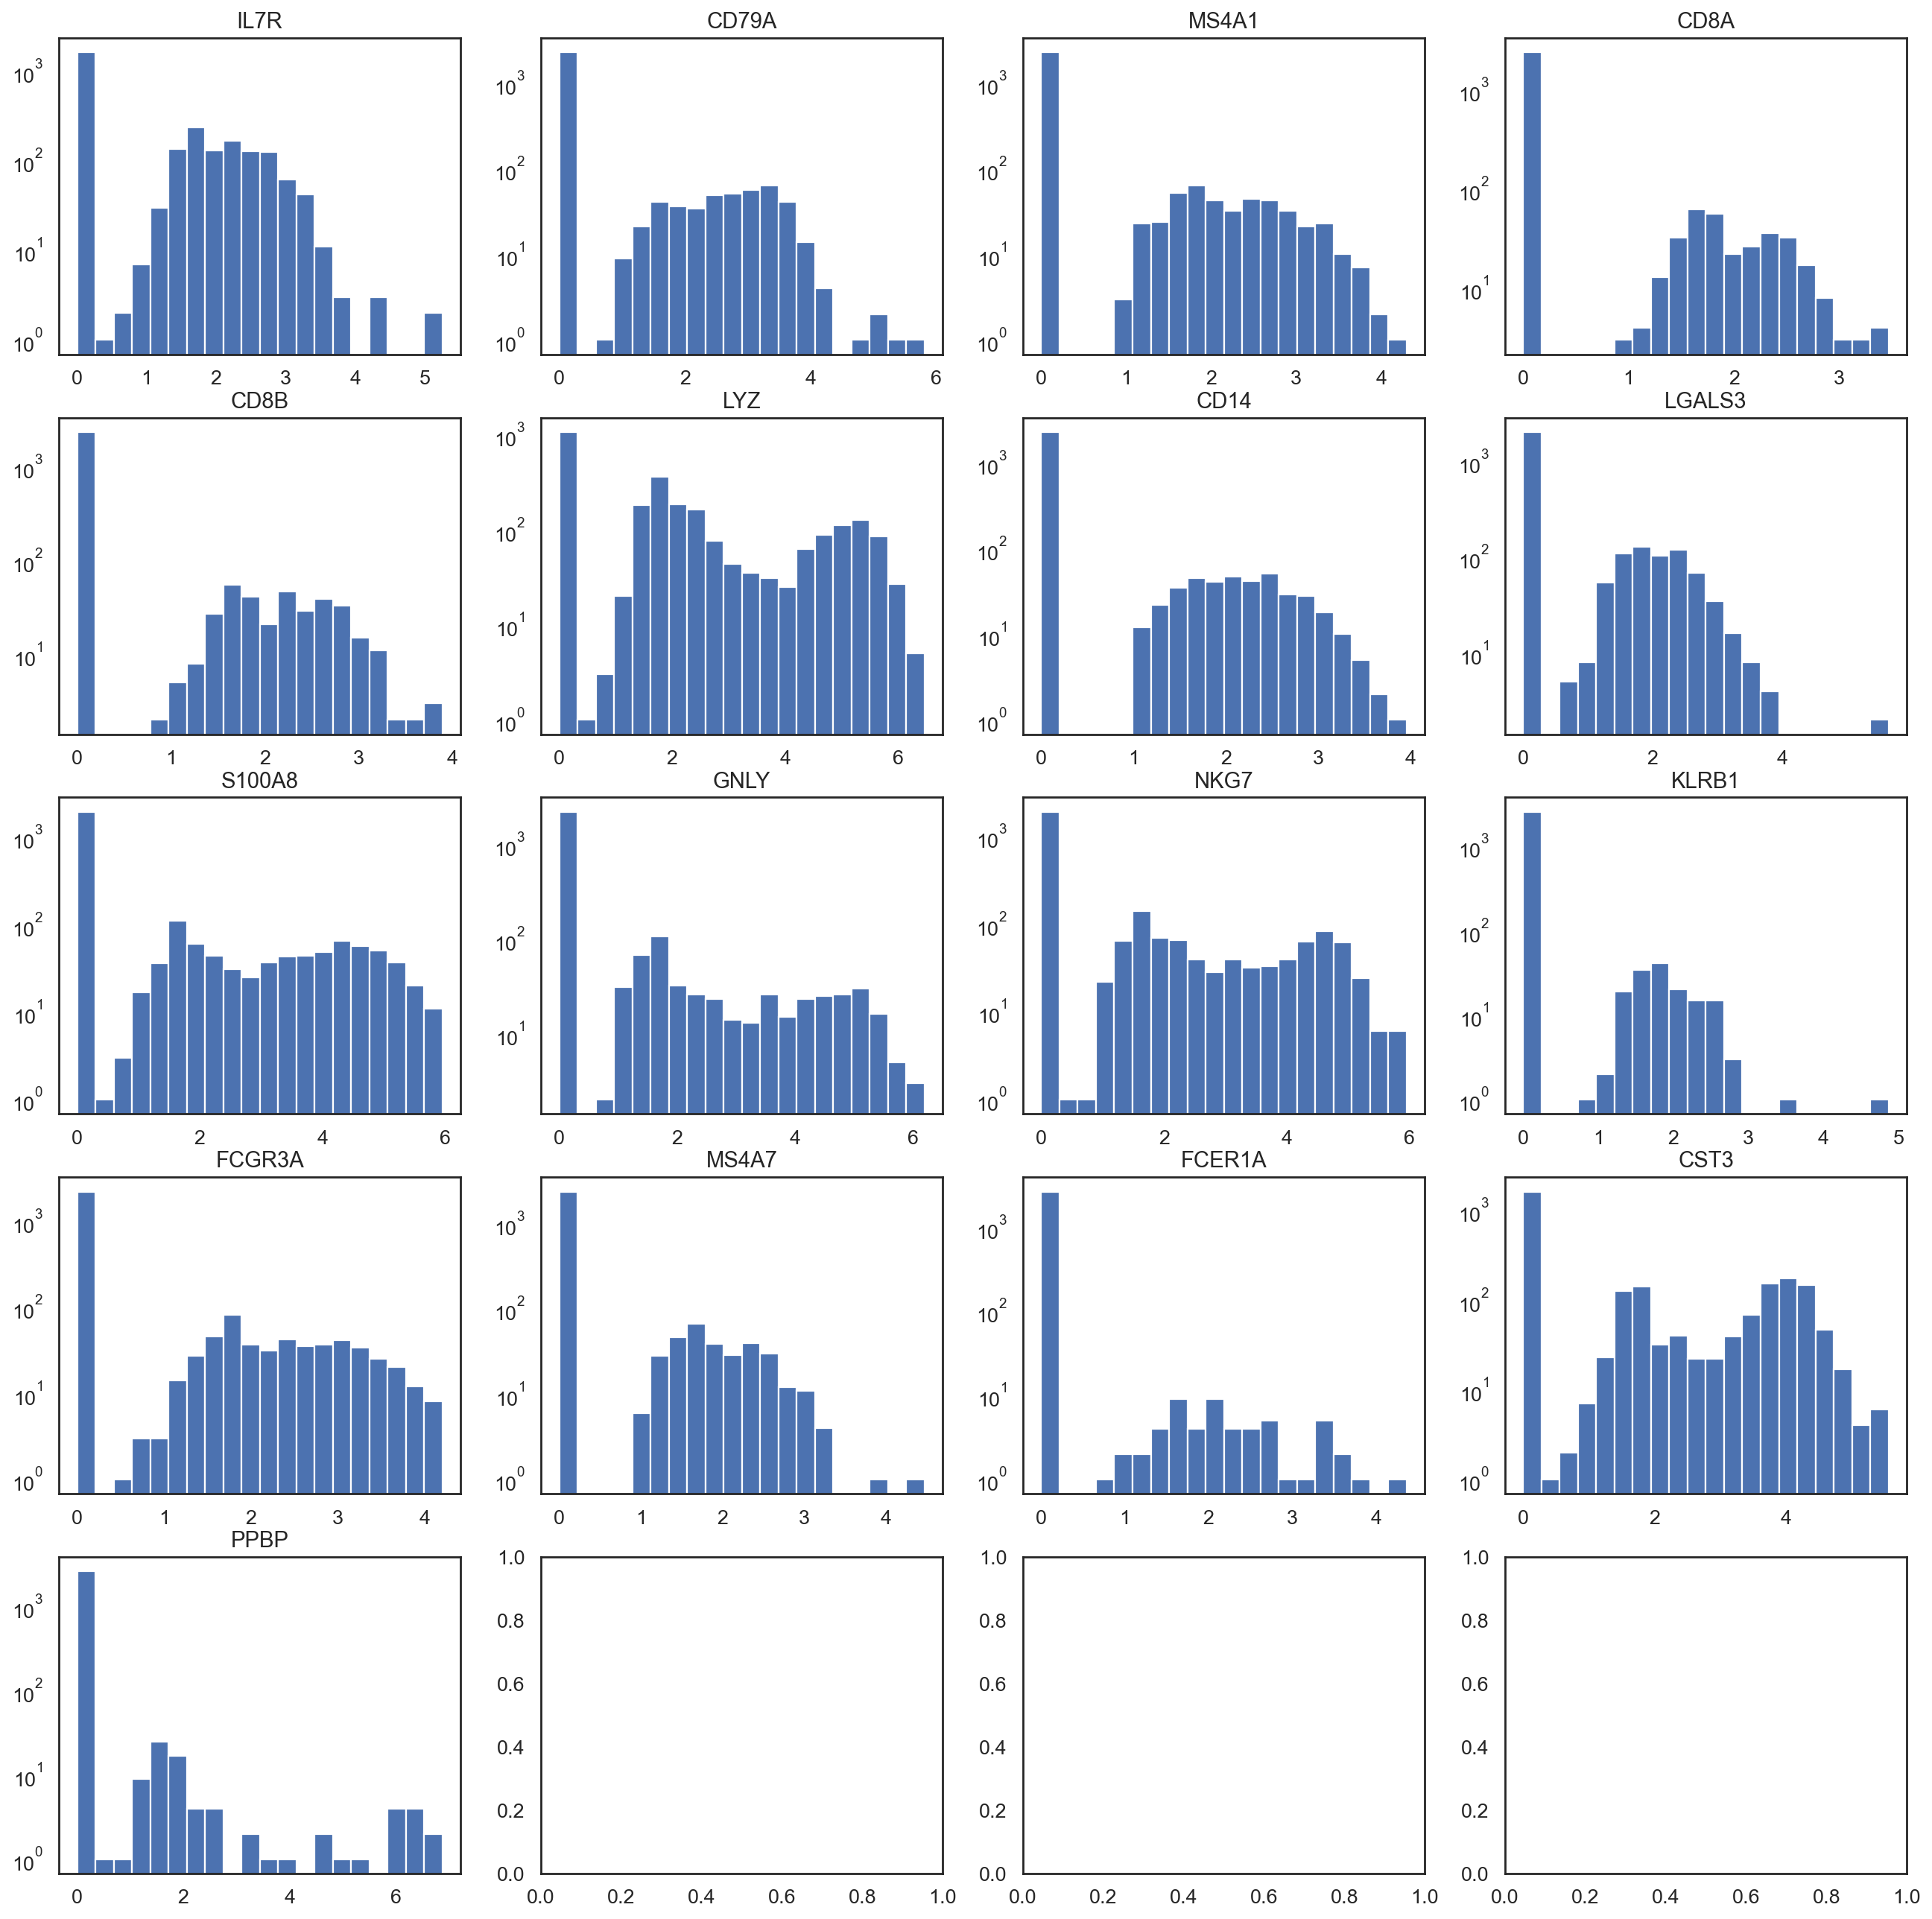

In [23]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(5,4,figsize=(20,20))
for i in range(len(marker_genes)):
    ax[i//4, i%4].hist(adata_CG[:,marker_genes[i]].X.toarray(), bins=20)
    ax[i//4, i%4].set_title(marker_genes[i])
    ax[i//4, i%4].set_yscale('log')

Optionally, variable gene selection step can be also performed. 

```python
si.pp.select_variable_genes(adata_CG, n_top_genes=2000)
si.pl.variable_genes(adata_CG,show_texts=True)
```

This will speed up the training procedure as only variable genes are encoded into the graph. But we won't obtain the embeddings of non-variable genes.

### discretize RNA expression

In [12]:
si.tl.discretize(adata_CG,n_bins=5)

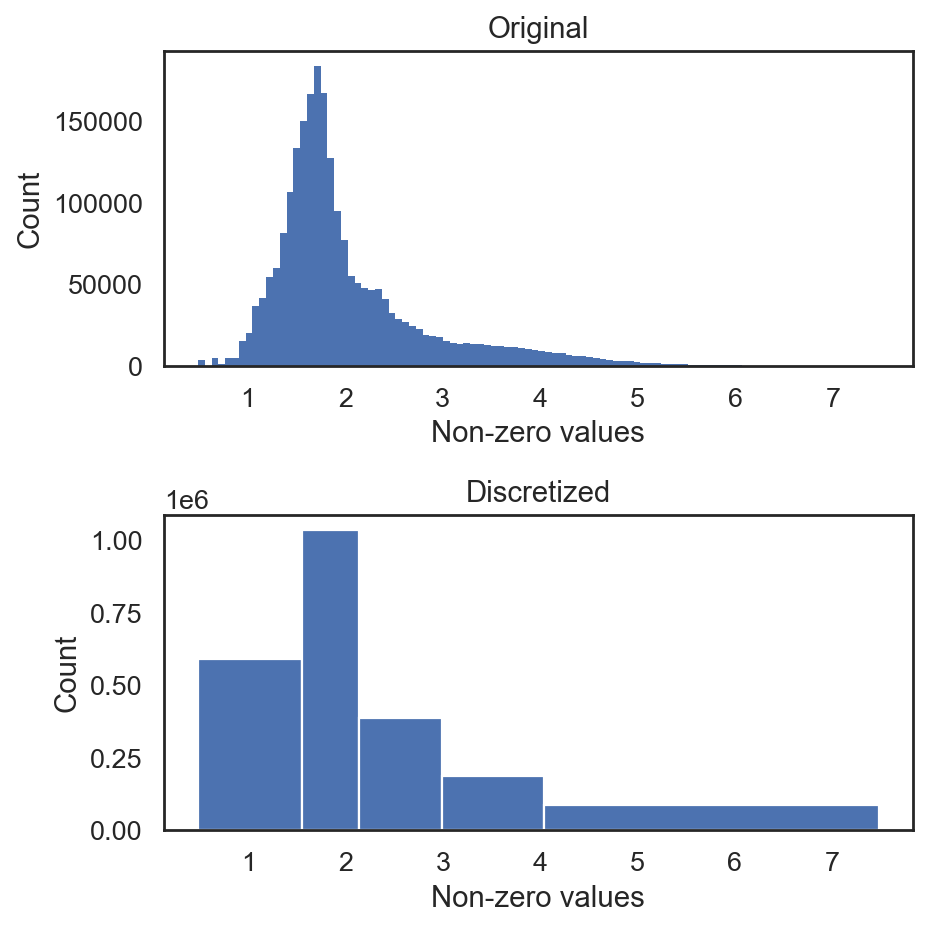

In [13]:
si.pl.discretize(adata_CG,kde=False)

### generate graph

In [14]:
si.tl.gen_graph(list_CG=[adata_CG],
                
                copy=False,
                use_highly_variable=False,
                dirname='graph0')

relation0: source: C, destination: G
#edges: 590134
relation1: source: C, destination: G
#edges: 1034817
relation2: source: C, destination: G
#edges: 384939
relation3: source: C, destination: G
#edges: 185485
relation4: source: C, destination: G
#edges: 87601
Total number of edges: 2282976
Writing graph file "pbg_graph.txt" to "result_simba_rnaseq_allgenes/pbg/graph0" ...
Finished.


### PBG training

Before PBG training, let's take a look at the parameters:

In [15]:
si.settings.pbg_params

{'entity_path': 'result_simba_rnaseq_allgenes/pbg/graph0/input/entity',
 'edge_paths': ['result_simba_rnaseq_allgenes/pbg/graph0/input/edge'],
 'checkpoint_path': '',
 'entities': {'C': {'num_partitions': 1}, 'G': {'num_partitions': 1}},
 'relations': [{'name': 'r0',
   'lhs': 'C',
   'rhs': 'G',
   'operator': 'none',
   'weight': 1.0},
  {'name': 'r1', 'lhs': 'C', 'rhs': 'G', 'operator': 'none', 'weight': 2.0},
  {'name': 'r2', 'lhs': 'C', 'rhs': 'G', 'operator': 'none', 'weight': 3.0},
  {'name': 'r3', 'lhs': 'C', 'rhs': 'G', 'operator': 'none', 'weight': 4.0},
  {'name': 'r4', 'lhs': 'C', 'rhs': 'G', 'operator': 'none', 'weight': 5.0}],
 'dynamic_relations': False,
 'dimension': 50,
 'global_emb': False,
 'comparator': 'dot',
 'num_epochs': 10,
 'workers': 4,
 'num_batch_negs': 50,
 'num_uniform_negs': 50,
 'loss_fn': 'softmax',
 'lr': 0.1,
 'early_stopping': False,
 'regularization_coef': 0.0,
 'wd': 0.0,
 'wd_interval': 50,
 'eval_fraction': 0.05,
 'eval_num_batch_negs': 50,
 'ev

If no parameters need to be adjusted, the training can be simply done with:

```python
si.tl.pbg_train(auto_wd=True, save_wd=True, output='model')
```

Here we show how to adjust training-related parameters if needed. In general, weight decay `wd` is the only parameter that might need to be adjusted based on the following pbg metric plots. However, in almost all the cases, the automatically decided `wd` (enabling it by setting `auto_wd=True`) works well.

E.g. we want to change `wd_interval`:

In [16]:
# modify parameters
dict_config = si.settings.pbg_params.copy()
# dict_config['wd'] = 0.015521 
dict_config['wd_interval'] = 10 # we usually set `wd_interval` to 10 for scRNA-seq datasets for a slower but finer training
dict_config['workers'] = 12 #The number of CPUs.

## start training
si.tl.pbg_train(pbg_params = dict_config, auto_wd=True, save_wd=True, output='model0')

Auto-estimated weight decay is 1.552147E-02
`.settings.pbg_params['wd']` has been updated to 1.552147E-02
Converting input data ...
[2022-11-15 19:49:29.424254] Found some files that indicate that the input data has already been preprocessed, not doing it again.
[2022-11-15 19:49:29.424734] These files are in: result_simba_rnaseq_allgenes/pbg/graph0/input/entity, result_simba_rnaseq_allgenes/pbg/graph0/input/edge
Starting training ...
Finished


> If `wd` is specified by users instead of being automatically decided, then make sure to update it in simba setting:
```python
si.settings.pbg_params = dict_config.copy()
```

The trained result can be loaded in with the following steps:

By default, it's using the current training result stored in `.setting.pbg_params`
```python
# load in graph ('graph0') info
si.load_graph_stats()
# load in model info for ('graph0')
si.load_pbg_config()
```
Users can also specify different pathss
```python
# load in graph ('graph0') info
si.load_graph_stats(path='./result_simba_rnaseq/pbg/graph0/')
# load in model info for ('graph0')
si.load_pbg_config(path='./result_simba_rnaseq/pbg/graph0/model/')
```

plotting training metrics to make sure the model is not overfitting

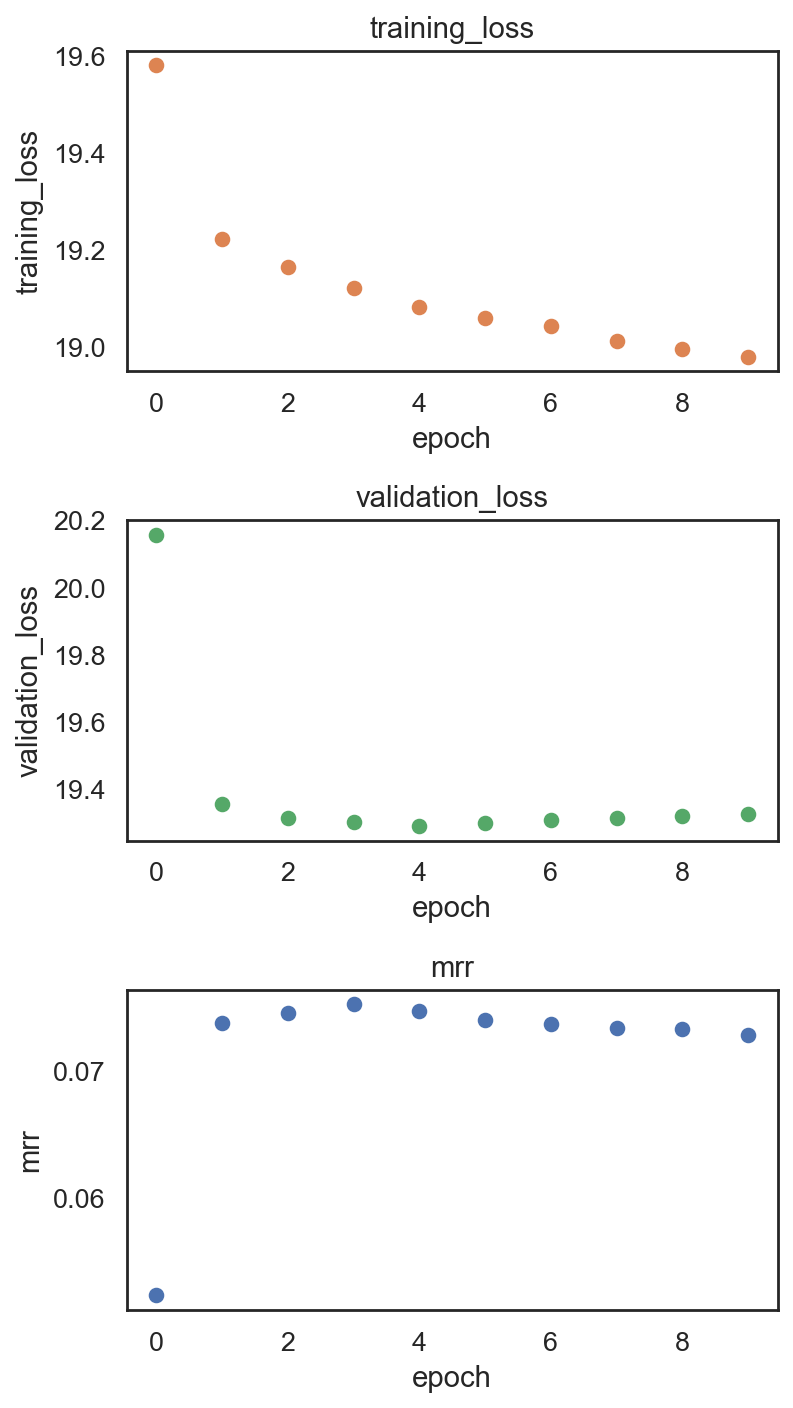

In [17]:
si.pl.pbg_metrics(fig_ncol=1)

### post-training analysis

In [18]:
palette_celltype={'B':'#1f77b4',
                  'CD4 T':'#ff7f0e', 
                  'CD8 T':'#279e68',
                  'Dendritic':"#aa40fc",
                  'CD14 Monocytes':'#d62728',
                  'FCGR3A Monocytes':'#b5bd61',
                  'Megakaryocytes':'#e377c2',
                  'NK':'#8c564b'}

In [19]:
dict_adata = si.read_embedding()

In [20]:
dict_adata

{'C': AnnData object with n_obs × n_vars = 2700 × 50,
 'G': AnnData object with n_obs × n_vars = 13714 × 50}

In [21]:
adata_C = dict_adata['C']  # embeddings for cells
adata_G = dict_adata['G']  # embeddings for genes

In [22]:
adata_C

AnnData object with n_obs × n_vars = 2700 × 50

In [23]:
adata_G

AnnData object with n_obs × n_vars = 13714 × 50

visualize embeddings of cells

In [24]:
## Add annotation of celltypes (optional)
adata_C.obs['celltype'] = adata_CG[adata_C.obs_names,:].obs['celltype'].copy()
adata_C

AnnData object with n_obs × n_vars = 2700 × 50
    obs: 'celltype'

In [25]:
si.tl.umap(adata_C,n_neighbors=15,n_components=2)

OMP: Info #277: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


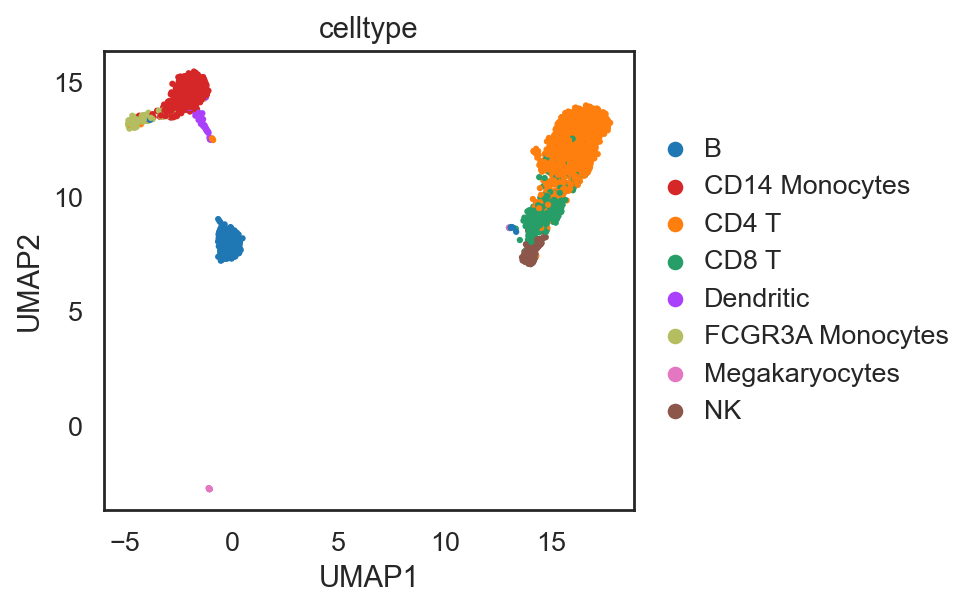

In [26]:
si.pl.umap(adata_C,color=['celltype'],
           dict_palette={'celltype': palette_celltype},
           fig_size=(6,4),
           drawing_order='random')

visualize embeddings of cells and genes

In [27]:
# embed cells and genes into the same space
adata_all = si.tl.embed(adata_ref=adata_C,list_adata_query=[adata_G])

Performing softmax transformation for query data 0;


In [28]:
adata_all.obs.head()

,celltype,id_dataset
ATCCCGTGCAGTCA-1,NK,ref
ATGAGCACATCTTC-1,CD4 T,ref
GGCCGATGCCGAAT-1,CD4 T,ref
CTACTATGTAAAGG-1,B,ref
CGAATCGAGGAGCA-1,CD14 Monocytes,ref


In [29]:
## add annotations of cells and genes
adata_all.obs['entity_anno'] = ""
adata_all.obs.loc[adata_C.obs_names, 'entity_anno'] = adata_all.obs.loc[adata_C.obs_names, 'celltype']
adata_all.obs.loc[adata_G.obs_names, 'entity_anno'] = 'gene'

In [30]:
adata_all.obs.head()

,celltype,id_dataset,entity_anno
ATCCCGTGCAGTCA-1,NK,ref,NK
ATGAGCACATCTTC-1,CD4 T,ref,CD4 T
GGCCGATGCCGAAT-1,CD4 T,ref,CD4 T
CTACTATGTAAAGG-1,B,ref,B
CGAATCGAGGAGCA-1,CD14 Monocytes,ref,CD14 Monocytes


In [31]:
si.tl.umap(adata_all,n_neighbors=15,n_components=2)

In [32]:
palette_entity_anno = palette_celltype.copy()
palette_entity_anno['gene'] = "#607e95"

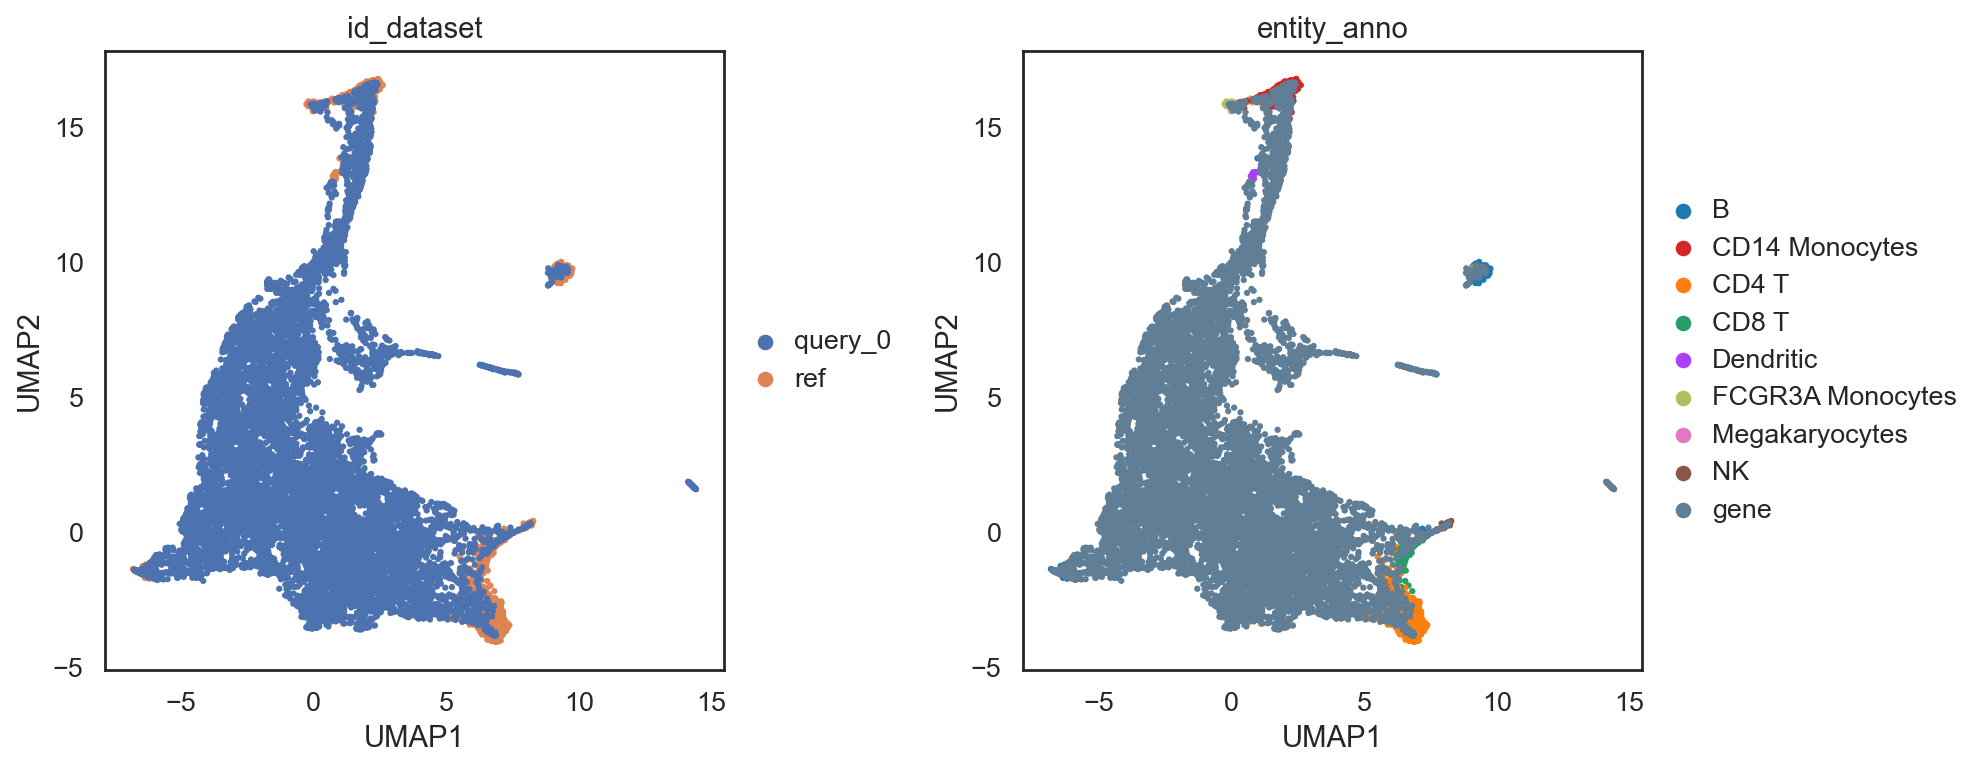

In [33]:
si.pl.umap(adata_all,color=['id_dataset','entity_anno'],
           dict_palette={'entity_anno': palette_entity_anno},
           drawing_order='original',
           fig_size=(6,5))

In [34]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

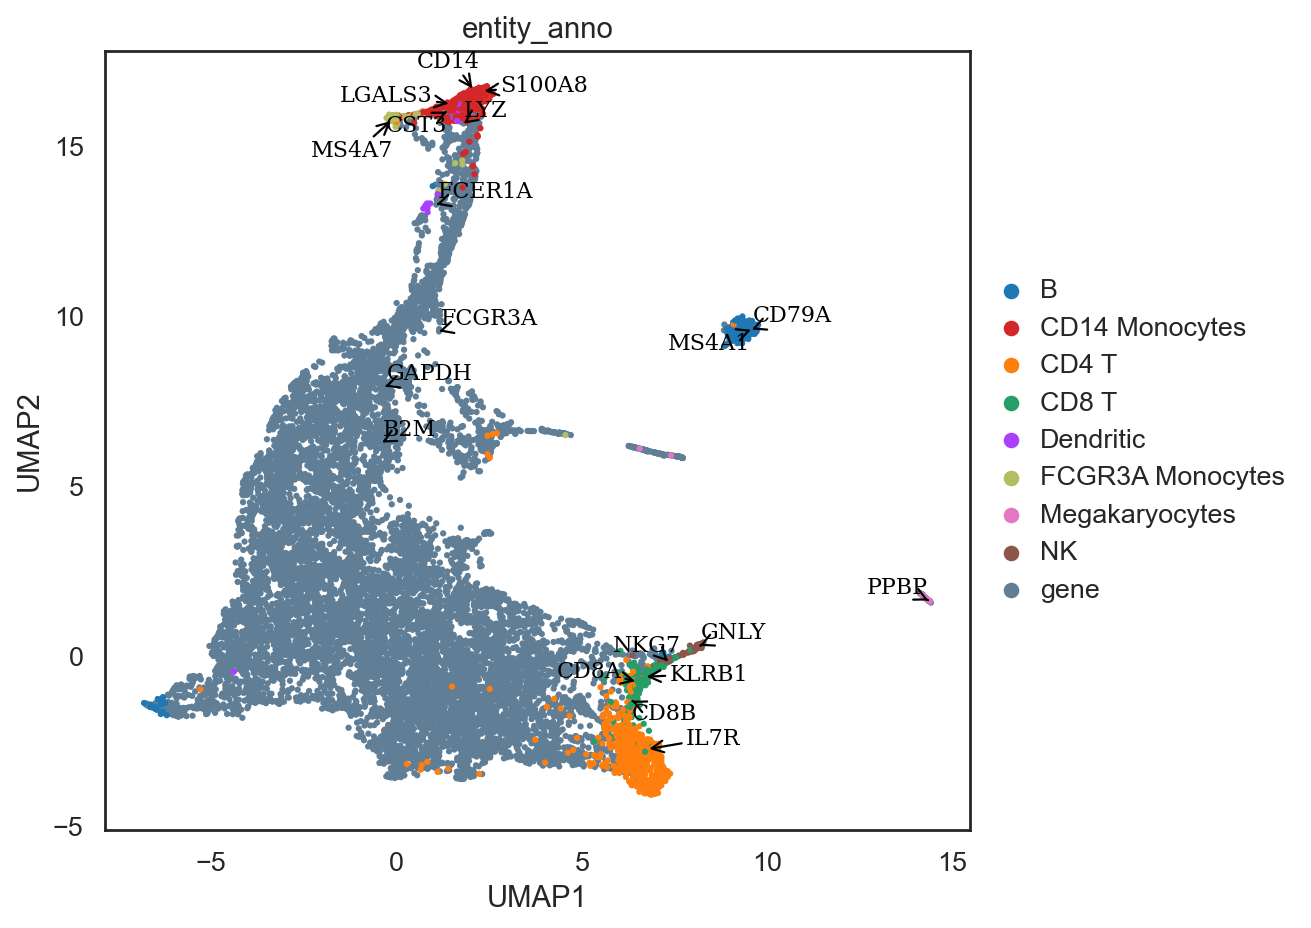

In [35]:
si.pl.umap(adata_all[::-1,],color=['entity_anno'],dict_palette={'entity_anno': palette_entity_anno},
           drawing_order='original',
           texts=marker_genes + ['GAPDH', 'B2M'],
           show_texts=True,
           fig_size=(8,6))

SIMBA metrics

In [36]:
adata_cmp = si.tl.compare_entities(adata_ref=adata_C, adata_query=adata_G)

In [37]:
adata_cmp

AnnData object with n_obs × n_vars = 2700 × 13714
    obs: 'celltype'
    var: 'max', 'maxmin', 'std', 'gini', 'entropy'
    layers: 'norm', 'softmax'

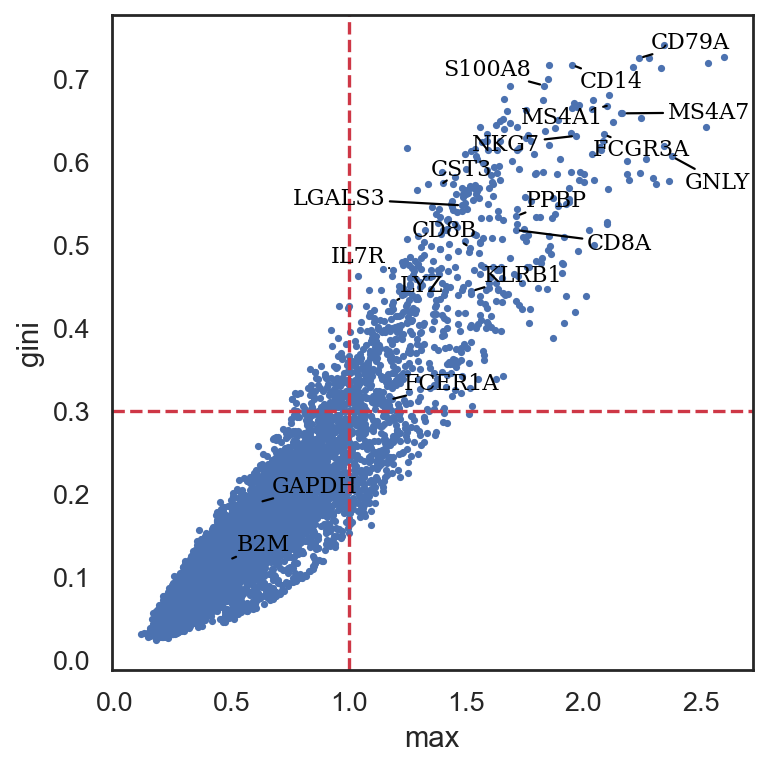

In [38]:
si.pl.entity_metrics(adata_cmp,
                     x='max',
                     y='gini',
                     show_contour=False,
                     texts=marker_genes + ['GAPDH', 'B2M'],
                     show_texts=True,
                     show_cutoff=True,
                     size=5,
                     text_expand=(1.3,1.5),
                     cutoff_x=1.,
                     cutoff_y=0.3,
                     save_fig=False)

SIMBA barcode plots

In [39]:
# add annoations of cells
adata_cmp.obs['celltype'] = adata_CG.obs.loc[adata_cmp.obs_names,'celltype']

In [40]:
list_genes = ['CST3', 'NKG7', 'MS4A1', 'GAPDH']

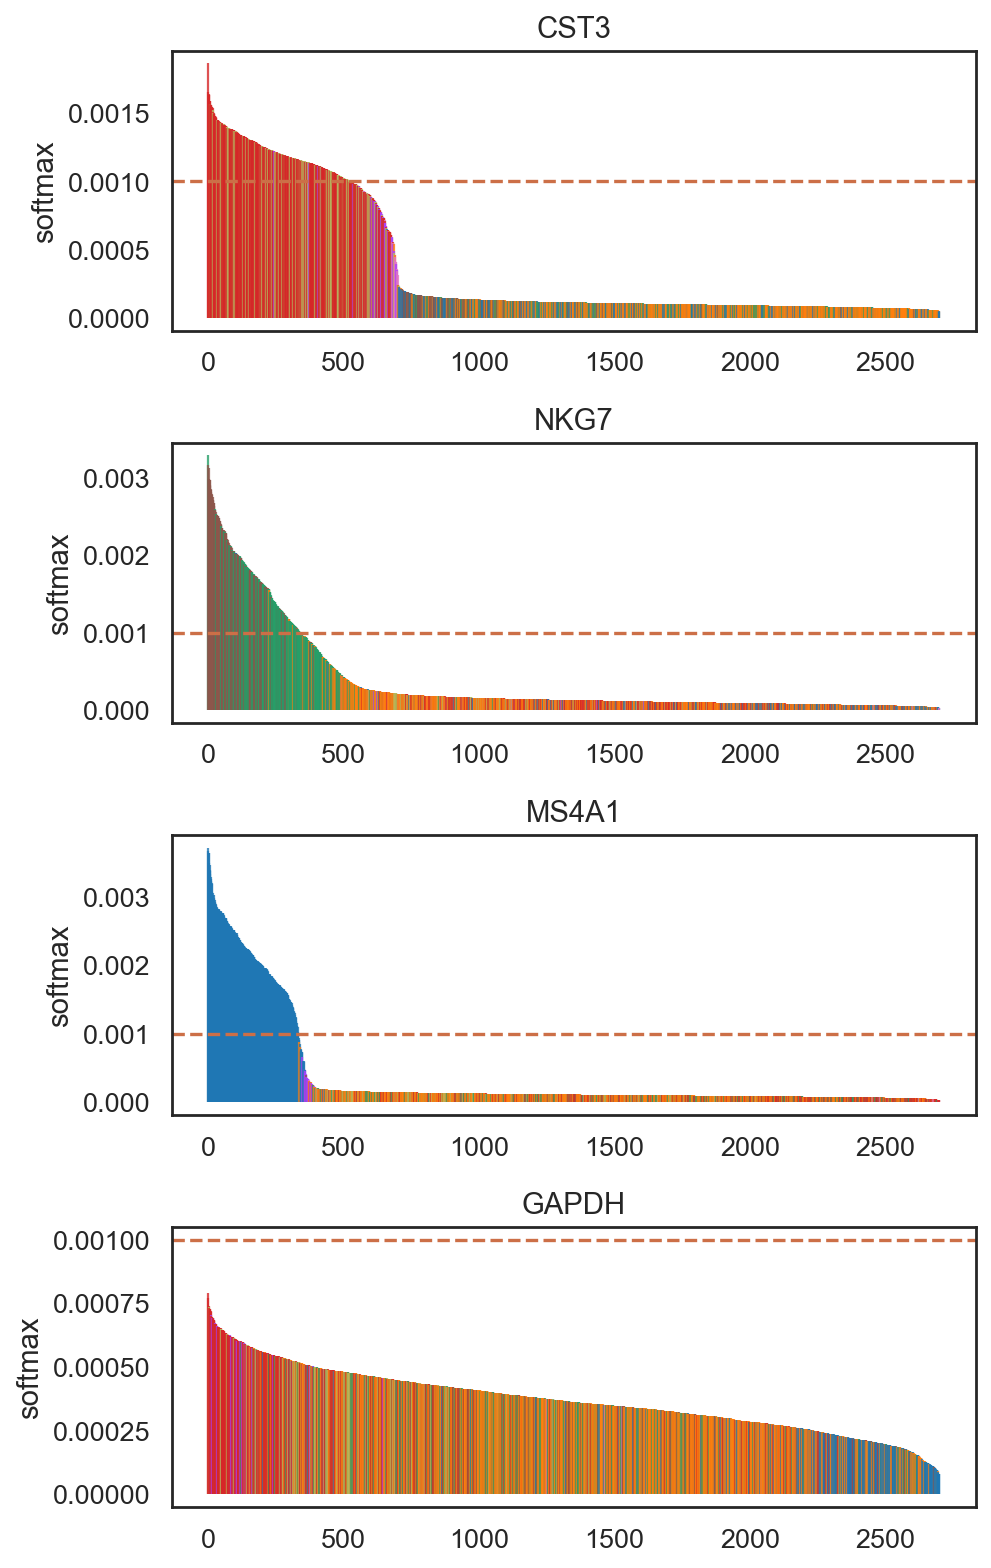

In [41]:
si.pl.entity_barcode(adata_cmp, 
                     layer='softmax',
                     entities=list_genes, 
                     anno_ref='celltype',
                     show_cutoff=True,
                     cutoff=0.001,
                     palette=palette_celltype,
                     fig_size=(6, 2.5),
                     save_fig=False)

visualize genes on umap of cells

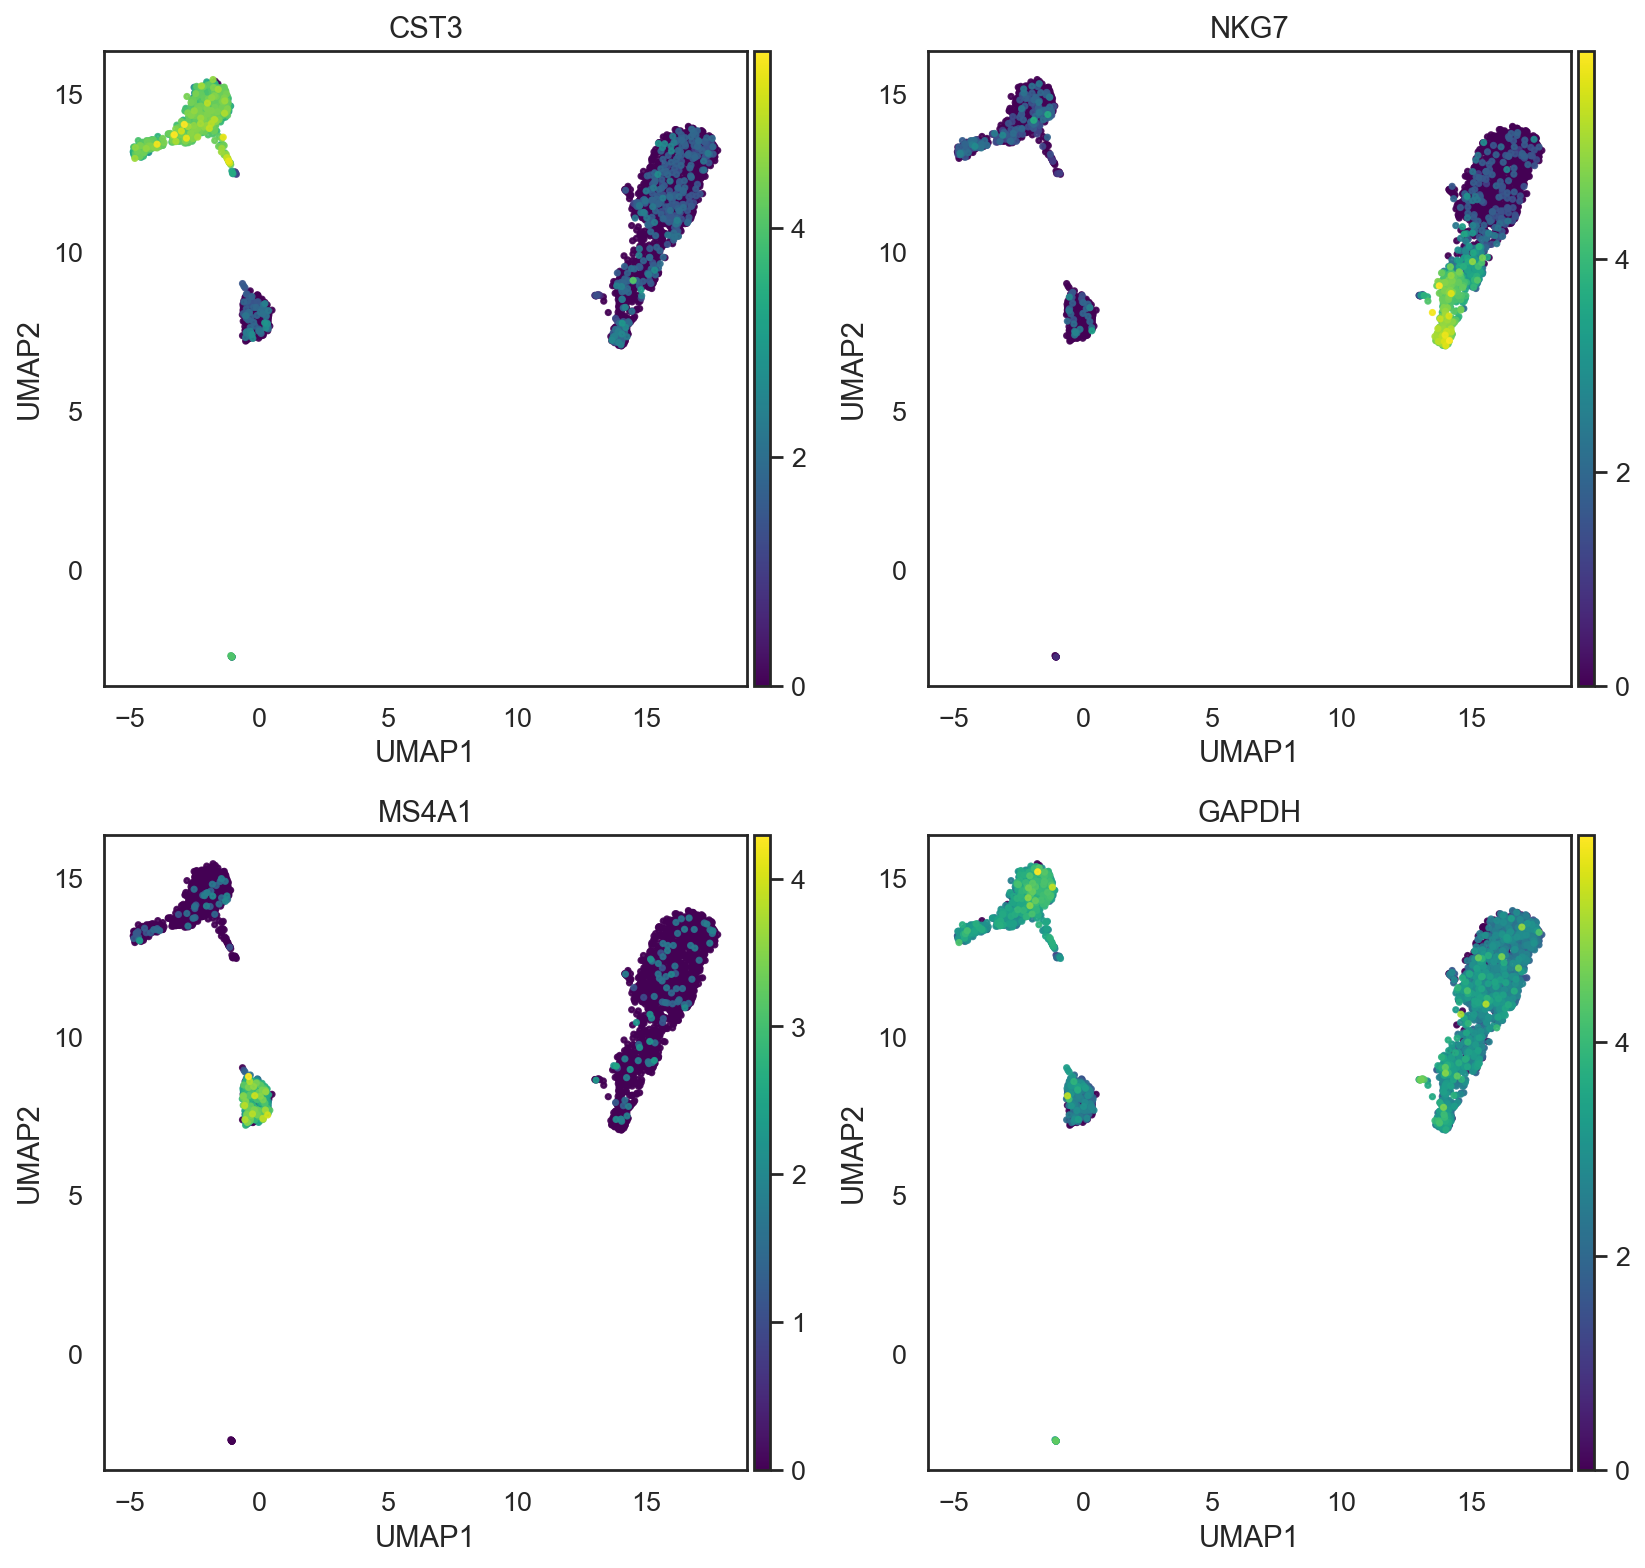

In [42]:
adata_CG.obsm['X_umap'] = adata_C[adata_CG.obs_names,].obsm['X_umap'].copy()
si.pl.umap(adata_CG,
           color=['CST3', 'NKG7', 'MS4A1', 'GAPDH'],
           drawing_order='sorted',
           size=5,
           alpha=0.9,
           fig_ncol=2,
           save_fig=False)

SIMBA queries

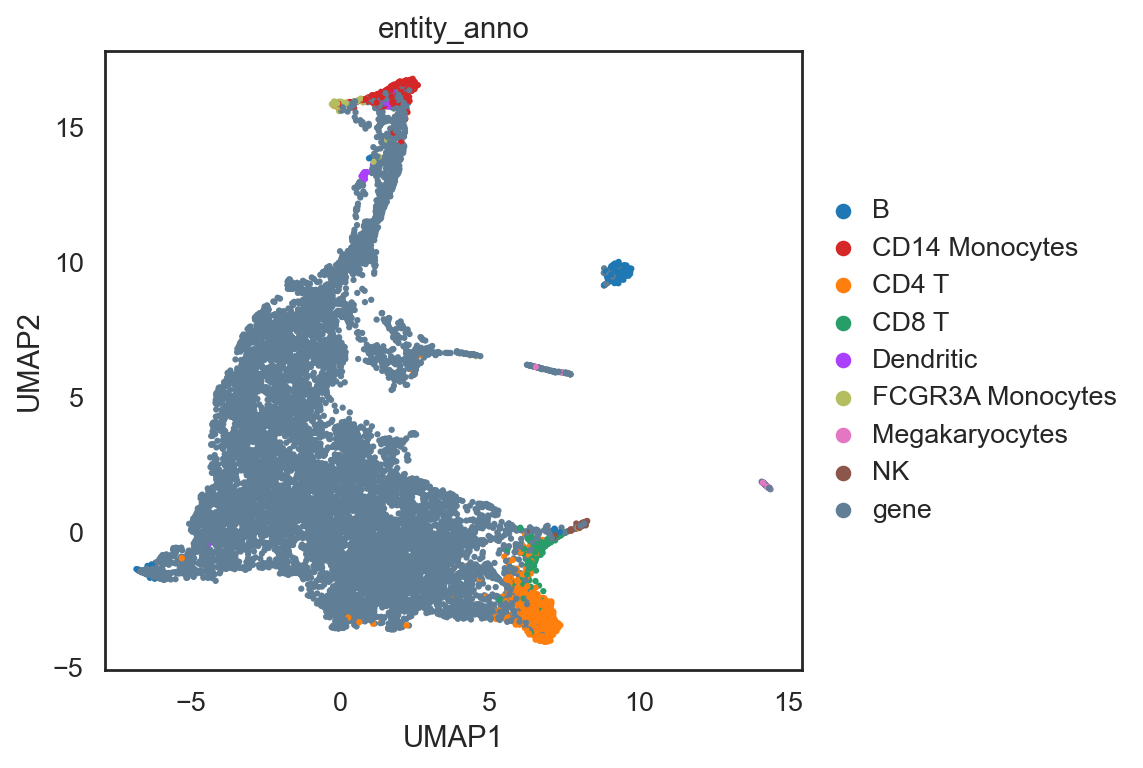

In [43]:
si.pl.umap(adata_all,
           color=['entity_anno'],dict_palette={'entity_anno': palette_entity_anno},
           drawing_order='random',
           show_texts=False,
           fig_size=(7,5))

In [44]:
# find neighbor genes around the location [6, 16] on UMAP
query_result = si.tl.query(adata_all,
                           pin=[6,16],
                           obsm='X_umap',
                           use_radius=True,r=2,
                           anno_filter='entity_anno',
                           filters=['gene'])
print(query_result.shape)
query_result.head()

(0, 5)


,celltype,id_dataset,entity_anno,distance,query


In [45]:
# show locations of pin point and its neighbor genes 
si.pl.query(adata_all,
            show_texts=False, 
            color=['entity_anno'], dict_palette={'entity_anno': palette_entity_anno},
            alpha=0.9,
            alpha_bg=0.1,
            fig_size=(7,5))

IndexError: arrays used as indices must be of integer (or boolean) type

In [ ]:
# find top 50 neighbor genes around cell "ACTCAGGATTCGTT-1" (CD14 Monocytes) in SIMBA space
query_result = si.tl.query(adata_all,
                           entity=['ACTCAGGATTCGTT-1'],
                           obsm=None,
                           use_radius=False,
                           k=50,
                           anno_filter='entity_anno',
                           filters=['gene'])
print(query_result.shape)
query_result.head()

In [ ]:
# show locations of entity and its neighbor genes 
si.pl.query(adata_all,
            obsm='X_umap',
            color=['entity_anno'], dict_palette={'entity_anno': palette_entity_anno},
            alpha=0.9,
            alpha_bg=0.1,
            fig_size=(7,5))

In [ ]:
# find top 50 neighbor genes for multiples cells in SIMBA space
query_result = si.tl.query(adata_all,entity=['GATGCCCTCTCATT-1', 'CTGAAGTGGCTATG-1'],
                           obsm=None,
                           use_radius=False,
                           k=50,
                           anno_filter='entity_anno',
                           filters=['gene'],
                           )
print(query_result.shape)
query_result.head()

In [ ]:
# show locations of entities and their neighbor genes 
si.pl.query(adata_all,
            obsm='X_umap',
            alpha=0.9,
            alpha_bg=0.1,            
            fig_size=(5,5))

In [ ]:
# find neighbor entities (both cells and genes) of a given gene on UMAP
query_result = si.tl.query(adata_all,
                           entity=['CD79A'],
                           obsm='X_umap',
                           use_radius=False,
                           k=50
                           )
print(query_result.shape)
query_result.iloc[:10,]

In [ ]:
si.pl.query(adata_all,
            obsm='X_umap',
            color=['entity_anno'], dict_palette={'entity_anno': palette_entity_anno},
            show_texts=False,
            alpha=0.9,
            alpha_bg=0.1,
            fig_size=(7,5))

### save results

In [48]:
workdir


'result_simba_rnaseq_allgenes'

In [47]:
# adata_CG.write(os.path.join(workdir, 'adata_CG.h5ad'))
# adata_C.write(os.path.join(workdir, 'adata_C.h5ad'))
# adata_G.write(os.path.join(workdir, 'adata_G.h5ad'))
# adata_all.write(os.path.join(workdir, 'adata_all.h5ad'))
adata_cmp.write(os.path.join(workdir, 'adata_cmp.h5ad'))

In [ ]:
adata_cmp.X

Read back anndata objects
```python
adata_CG = si.read_h5ad(os.path.join(workdir, 'adata_CG.h5ad'))
adata_C = si.read_h5ad(os.path.join(workdir, 'adata_C.h5ad'))
adata_G = si.read_h5ad(os.path.join(workdir, 'adata_G.h5ad'))
adata_all = si.read_h5ad(os.path.join(workdir, 'adata_all.h5ad'))
adata_cmp = si.read_h5ad(os.path.join(workdir, 'adata_cmp.h5ad'))
```